# Zonotope Analysis Part 1
In commit `3e70619` we have implemented a working version of Zonotope propagation without refinement.
The current version (still?) uses LP solving on every split in order to avoid an explosion of Zonotopes.

Questions we are interested in:
- At what depth do we show equivalence/at what depth does the Zonotope become infeasible?
- How precise is the equivalence we show? For how many cases do we need refinement?

In [1]:
import parse
import matplotlib.pyplot as plt
import numpy as np

In [2]:
acas_1_1 = parse.BenchmarkRun("../results/ACASXU_run2a_1_1_batch_2000-trunc/1/nnequiv-3e70619/stdout.log","../results/ACASXU_run2a_1_1_batch_2000-trunc/1/nnequiv-3e70619/stderr.log")
acas_1_2 = parse.BenchmarkRun("../results/ACASXU_run2a_1_2_batch_2000-trunc/1/nnequiv-3e70619/stdout.log","../results/ACASXU_run2a_1_2_batch_2000-trunc/1/nnequiv-3e70619/stderr.log")
har = parse.BenchmarkRun("../results/HAR-trunc/1/nnequiv-21af8ae/stdout.log","../results/HAR-trunc/1/nnequiv-21af8ae/stderr.log")

## Decision Depth Histogram

/home/steuber/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


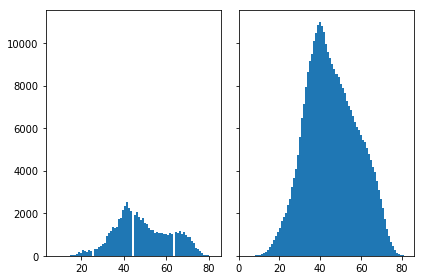

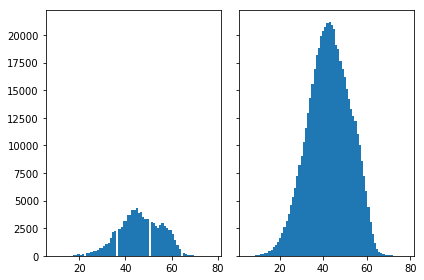

In [3]:
%matplotlib inline
def plot_depth_hist(run):
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    max_val = max(max(run.depth.valid_depth),max(run.depth.invalid_depth))
    min_val = min(min(run.depth.valid_depth),min(run.depth.invalid_depth))
    n_bins = max_val-min_val+1

    # We can set the number of bins with the `bins` kwarg
    return (axs[0].hist(run.depth.valid_depth, bins=n_bins),
    axs[1].hist(run.depth.invalid_depth, bins=n_bins))

depth_hists_1_1=plot_depth_hist(acas_1_1)
depth_hists_1_2=plot_depth_hist(acas_1_2)

## Shown (Non-)Equivalence

Non Equivalent: 0
Non Equivalent: 0
Non Equivalent: 8880
Max: 1.6747442483901978


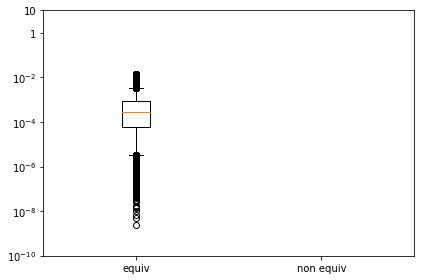

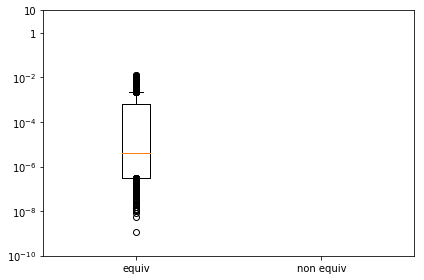

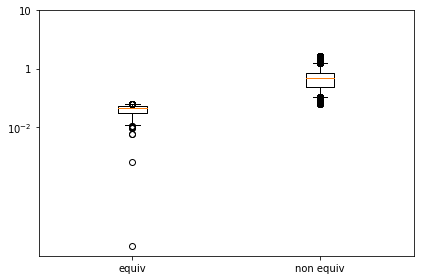

In [4]:
%matplotlib inline
def plot_equiv_hist(run,ticks=(1,0, -2,-4,-6,-8,-10),labels=("10","1","$10^{-2}$","$10^{-4}$","$10^{-6}$","$10^{-8}$","$10^{-10}$")):
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    n_bins =80
    print(f"Non Equivalent: {len(run.equiv.nonequiv)}")
    if len(run.equiv.nonequiv)>0:
        print(f"Max: {max(run.equiv.nonequiv)}")
    # We can set the number of bins with the `bins` kwarg
    #return (axs[0].hist(run.equiv.equiv, bins=n_bins),
    #axs[1].hist(run.equiv.nonequiv, bins=n_bins))
    plt.boxplot([np.log10(run.equiv.equiv), np.log10(np.array(run.equiv.nonequiv))],whis=(5,95))
    plt.xticks(ticks=(1,2),labels=("equiv", "non equiv"))
    plt.yticks(ticks=ticks,labels=labels)

equiv_hists_1_1=plot_equiv_hist(acas_1_1)
equiv_hists_1_2=plot_equiv_hist(acas_1_2)
equiv_hists_har=plot_equiv_hist(har,ticks=[1,0,-1])

# Zonotope Analysis Part 2

In commit `3f00a06` we evaluate the same Zonotope propagation as previously, however we run it on the full property 1 (a first for our GPE approach) and we track the distances from 0 at splits (i.e. the overlap across the 0).

Questions we are interested in:

- Is there a (somewhat) clear distinction between the overlap for invalid splits and the overlap for valids splits?



In [5]:
acas_1_1 = parse.BenchmarkRun("../results/ACASXU_run2a_1_1_batch_2000-trunc/1/nnequiv-3f00a06/stdout.log","../results/ACASXU_run2a_1_1_batch_2000-trunc/1/nnequiv-3f00a06/stderr.log")
acas_1_2 = parse.BenchmarkRun("../results/ACASXU_run2a_1_2_batch_2000-trunc/1/nnequiv-3f00a06/stdout.log","../results/ACASXU_run2a_1_2_batch_2000-trunc/1/nnequiv-3f00a06/stderr.log")

Handling depth_offset (may take some time)
 [(0.044984847, 5), (0.02796534, 6), (0.054615185, 7), (0.054125533, 8), (0.
Handling depth_offset (may take some time)
Handling depth_offset (may take some time)
 [(0.050202943, 7), (0.04684838, 10), (0.034162328, 11), (0.03180854, 12), (
Handling depth_offset (may take some time)


## Once again the Depth Histograms
For comparison to restricted property 1...

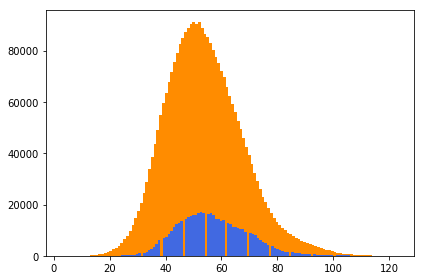

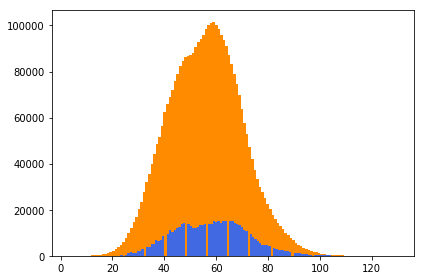

In [18]:
def plot_hists_depth(run):
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    valid = np.array(run.depth.valid_depth,dtype=np.int)
    invalid = np.array(run.depth_offset.invalid_depth[:,1],dtype=np.int)
    max_val = max(np.max(valid),np.max(invalid))
    min_val = min(np.min(valid),np.min(invalid))
    n_bins = max_val-min_val+1

    # We can set the number of bins with the `bins` kwarg
    axs.hist(invalid, bins=n_bins,color='darkorange')
    axs.hist(valid, bins=n_bins,color='royalblue')
plot_hists_depth(acas_1_1)
plot_hists_depth(acas_1_2)

In [50]:
import scipy.stats as stats

In [53]:
v_fit_alpha, v_fit_loc, v_fit_beta=stats.gamma.fit(acas_1_1.depth_offset.valid_depth[:,0])
i_fit_alpha, i_fit_loc, i_fit_beta=stats.gamma.fit(acas_1_1.depth_offset.invalid_depth[:,0])
print((v_fit_alpha, v_fit_loc, v_fit_beta))
print((i_fit_alpha, i_fit_loc, i_fit_beta))

(0.0323159329947997, 0.00010046362999982868, 2.5048903970693925)
(0.017635951325769547, 0.00010015070399999999, 0.8957861844715469)


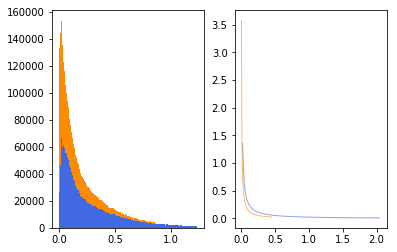

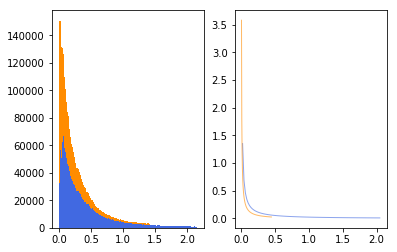

In [59]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
def plot_hists_depth(run, v_fit, i_fit):
    fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=False)
    valid = reject_outliers(run.depth_offset.valid_depth[:,0],1)
    invalid = reject_outliers(run.depth_offset.invalid_depth[:,0],1)
    v_fit_alpha, v_fit_loc, v_fit_beta = v_fit
    i_fit_alpha, i_fit_loc, i_fit_beta = i_fit
    # We can set the number of bins with the `bins` kwarg
    axs[0].hist([valid,invalid], bins='auto',color=['royalblue','darkorange'],stacked=True)
    x = np.linspace(stats.gamma.ppf(0.01, v_fit_alpha, v_fit_loc, v_fit_beta), stats.gamma.ppf(0.99, v_fit_alpha, v_fit_loc, v_fit_beta), 100)
    axs[1].plot(x, stats.gamma.pdf(x, v_fit_alpha, v_fit_loc, v_fit_beta), lw=1, alpha=0.6, label='gamma pdf',color='royalblue')
    x = np.linspace(stats.gamma.ppf(0.01, i_fit_alpha, i_fit_loc, i_fit_beta), stats.gamma.ppf(0.99, i_fit_alpha, i_fit_loc, i_fit_beta), 100)
    axs[1].plot(x, stats.gamma.pdf(x, i_fit_alpha, i_fit_loc, i_fit_beta), lw=1, alpha=0.6, label='gamma pdf',color='darkorange')
    #axs.hist(invalid, bins='auto',color='darkorange',stacked=True)
v_fit_1_1=stats.gamma.fit(acas_1_1.depth_offset.valid_depth[:,0])
i_fit_1_1=stats.gamma.fit(acas_1_1.depth_offset.invalid_depth[:,0])
plot_hists_depth(acas_1_1,v_fit_1_1,i_fit_1_1)
v_fit_1_2=stats.gamma.fit(acas_1_2.depth_offset.valid_depth[:,0])
i_fit_1_2=stats.gamma.fit(acas_1_2.depth_offset.invalid_depth[:,0])
plot_hists_depth(acas_1_2,v_fit_1_1,i_fit_1_1)

### Results
We see:
- Depth distributed according to normal distribution
- Overlap distributed according to gamma Distribution(?)


#### Unfinished:

We now try to compute the conditional probability of a split being valid/invalid for a given overlap.
Using bayes formula:
$$
P\left[v \mid o\right] = \frac{P\left[o \mid v \right] * P\left[v\right]}{P\left[o\right]}
$$

We obtain $P\left[o\right]$ by fitting on all overlaps.  
We obtain $P\left[v\right]$ by looking at the share of valid splits.  
We obtain $P\left[o \mid v \right]$ through the fits above

In [61]:
o_fit_alpha, o_fit_loc, o_fit_beta = stats.gamma.fit(np.append(acas_1_1.depth_offset.valid_depth[:,0],acas_1_1.depth_offset.invalid_depth[:,0]))

0.5716615177211023
[0.         0.01213662 0.0189173  0.02366989 0.02733448 0.03031616
 0.03282798 0.03499625 0.03690217 0.03860106 0.04013237 0.04152521
 0.0428017  0.04397902 0.04507082 0.0460881  0.04703986 0.04793356
 0.04877546 0.04957086 0.05032427 0.0510396  0.05172022 0.05236907
 0.05298875 0.05358153 0.05414945 0.05469432 0.05521774 0.05572118
 0.05620594 0.05667322 0.05712408 0.05755952 0.05798042 0.05838762
 0.05878186 0.05916384 0.0595342  0.05989352 0.06024237 0.06058125
 0.06091063 0.06123095 0.06154262 0.06184603 0.06214154 0.06242948
 0.06271016 0.0629839  0.06325096 0.06351161 0.0637661  0.06401465
 0.0642575  0.06449486 0.06472691 0.06495385 0.06517587 0.06539311
 0.06560576 0.06581396 0.06601786 0.06621759 0.0664133  0.0666051
 0.06679311 0.06697746 0.06715826 0.0673356  0.0675096  0.06768034
 0.06784792 0.06801243 0.06817396 0.06833258 0.06848838 0.06864143
 0.06879181 0.06893959 0.06908482 0.06922759 0.06936795 0.06950596
 0.06964168 0.06977517 0.06990648 0.07003566

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

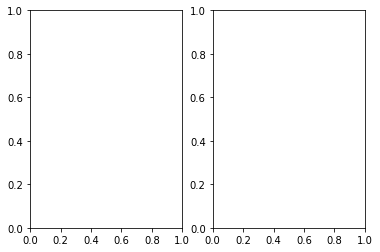

In [117]:
import scipy
p_valid = len(acas_1_1.depth_offset.valid_depth[:,0])/(len(acas_1_1.depth_offset.valid_depth[:,0])+len(acas_1_1.depth_offset.invalid_depth[:,0]))
print(p_valid)
#x = np.linspace(0.0, 100, 10000)
x = np.linspace(stats.gamma.ppf(0.01, i_fit_alpha, i_fit_loc, i_fit_beta), stats.gamma.ppf(0.99, i_fit_alpha, i_fit_loc, i_fit_beta), 100)
v_fit_alpha, v_fit_loc, v_fit_beta = v_fit_1_1
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=False)
#axs.plot(x, stats.gamma.pdf(x, o_fit_alpha, o_fit_loc, o_fit_beta), lw=1, alpha=0.6, label='gamma pdf',color='black')
print(scipy.integrate.cumtrapz(stats.gamma.pdf(x, i_fit_alpha, i_fit_loc, i_fit_beta)[1:],x[1:], initial=0.0))
print(scipy.integrate.cumtrapz(((stats.gamma.pdf(x, v_fit_alpha, v_fit_loc, v_fit_beta)*p_valid)/stats.gamma.pdf(x, o_fit_alpha, o_fit_loc, o_fit_beta))[1:],x[1:]))
axs[0].plot(x, np.trapz((stats.gamma.pdf(x, v_fit_alpha, v_fit_loc, v_fit_beta)*p_valid)/stats.gamma.pdf(x, o_fit_alpha, o_fit_loc, o_fit_beta),x), lw=1, alpha=0.6, label='gamma pdf',color='royalblue')
i_fit_alpha, i_fit_loc, i_fit_beta = i_fit_1_1
axs[0].plot(x, (stats.gamma.pdf(x, i_fit_alpha, i_fit_loc, i_fit_beta)*(1-p_valid))/stats.gamma.pdf(x, o_fit_alpha, o_fit_loc, o_fit_beta), lw=1, alpha=0.6, label='gamma pdf',color='darkorange')
#axs[1].semilogy(basey=2)
#axs[1].plot(x, (stats.gamma.pdf(x, v_fit_alpha, v_fit_loc, v_fit_beta)*p_valid)/stats.gamma.pdf(x, o_fit_alpha, o_fit_loc, o_fit_beta)/(stats.gamma.pdf(x, i_fit_alpha, i_fit_loc, i_fit_beta)*(1-p_valid))/stats.gamma.pdf(x, o_fit_alpha, o_fit_loc, o_fit_beta), lw=1, alpha=0.6, label='gamma pdf',color='black')